---
title: Whose Costs? - 'Optimal Decision Making'
author: Sophie Seiple
date: '2024-02-28'
image: "bank.jpg"
description: "Determining the maximum profit of a bank on a dataset of loan applicants."
format: html
---

## ABSTRACT

In this post I sought to find a model for determining the maximum profit possible for a set of loan applicants. The model scores applicants based on their comparative risk of defaulting, and according to the optimal threshold value, any applicants over this threshold (t) are approved and their outcomes are factored into the profits and losses. I use logistic regression to determine the weights for each feature of the model, using all available features aside from loan grade, and scipy's optimization function, minimize_scalar, to find the corresponding optimal threshold value. My findings were that the optimal profit was around 7.2 million dollars, with a threshold of 0.6047470824523236. Through analysis of the model results I also explore questions of model fairness, including the rate at which medical loans are approved and the effect of an applicant's age and income on loan approval rates.

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

In [2]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


## PART B: DATA EXPLORATION

#### FIGURE 1: How does loan intent vary with home ownership status?

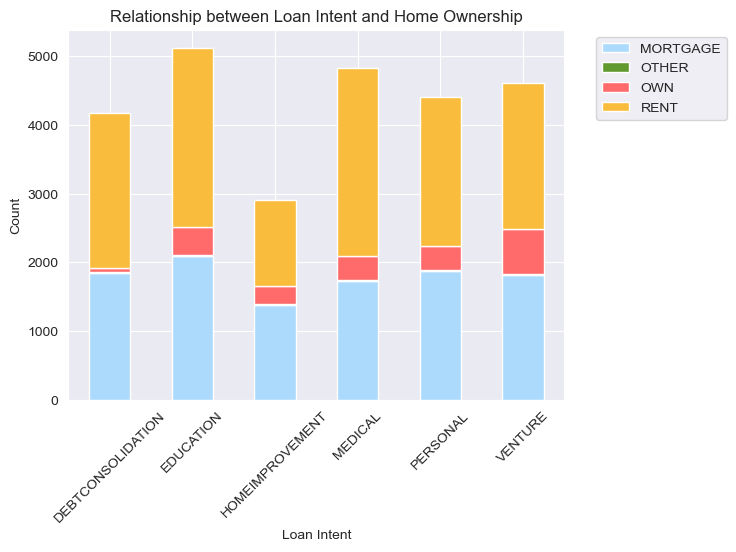

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 

cross_tab = pd.crosstab(df_train['loan_intent'], df_train['person_home_ownership'])

colors = ["#abdafc", "#60992d", "#ff6b6b", "#fabc3c"]
sns.set_style("darkgrid")

cross_tab.plot(kind='bar', stacked=True, color = colors)
plt.xlabel('Loan Intent')
plt.ylabel('Count')
plt.title('Relationship between Loan Intent and Home Ownership')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


This figure explores the intent of loans by home ownsership status. From this we can see that the majority of applicants either rent, or have a mortgage on their homes. A small group own their homes, and are least likely to apply for debt consolidation purposes, and most likely to apply for venture or education purposes. Those who rent are likely to apply for education, debt consolidation, or medical purposes, but also have not insignificant numbers across intents. 

#### FIGURE 2: How does the percentage of income a loan makes up vary by age. Entries with ages above 100 (4 entries) were removed for ease of plotting and because they were generally outliers.

In [4]:
print((df_train["person_age"] > 100).sum())

4


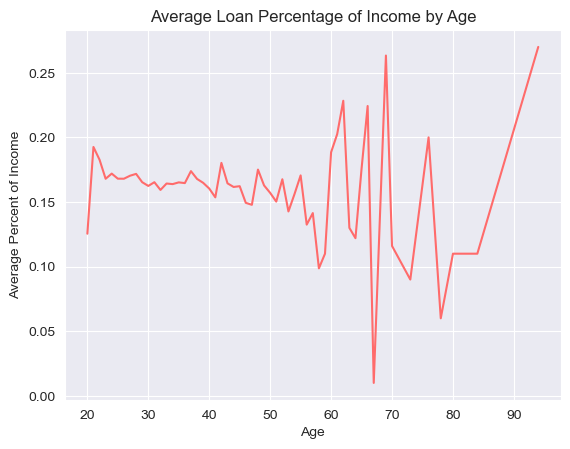

In [5]:
import numpy as np
graph_data = pd.DataFrame()
graph_data['age'] = df_train["person_age"] 
graph_data['percent'] = df_train['loan_percent_income']
graph_data.replace([np.inf, -np.inf], np.nan, inplace=True)
avg_percent_income = graph_data.groupby('age')['percent'].mean().reset_index()
avg_percent_income = avg_percent_income[avg_percent_income['age'] <= 100]

plt.plot(avg_percent_income['age'], avg_percent_income['percent'], marker='', linestyle='-', color = "#ff6b6b")
plt.xlabel('Age')
plt.ylabel('Average Percent of Income')
plt.title('Average Loan Percentage of Income by Age')
plt.show()

This graph shows the average percentage of an applicants income a loan makes up by age. While there isn't a clear pattern, we see that after age 60 generally loans are a comparatively large percentage of income. This doesn't necessary imply that those over 60 are applying for larger loans, but more likely that they are beginning to retire and therefore their income is substantially lower. For ease of graphing I removed entries over 100, of which there were only 4.

#### FIGURE 3: How does loan size vary with age?</u>

In [6]:
graph_data = df_train
graph_data.dropna()
bins = [20, 30, 40, 50, 60, float('inf')] 
labels = ['20-30', '30-40', '40-50', '50-60', '60+']
graph_data['age_subset'] = pd.cut(graph_data['person_age'], bins=bins, labels=labels, right=False)

summary_table = graph_data.groupby('age_subset', observed=False)['loan_amnt'].agg(['count', 'mean', 'min', 'max']).round(2).reset_index()
summary_table.columns = ['Age Group', 'Count', 'Mean Loan Size', 'Min Loan Size', 'Max Loan Size']

summary_table['Count'] = summary_table['Count'].apply(lambda x: '{:,.0f}'.format(x))
summary_table['Mean Loan Size'] = summary_table['Mean Loan Size'].apply(lambda x: '${:,.2f}'.format(x))
summary_table['Min Loan Size'] = summary_table['Min Loan Size'].apply(lambda x: '${:,.2f}'.format(x))
summary_table['Max Loan Size'] = summary_table['Max Loan Size'].apply(lambda x: '${:,.2f}'.format(x))

styled_table = summary_table.style.format({
})

styled_table

,Age Group,Count,Mean Loan Size,Min Loan Size,Max Loan Size
0,20-30,"18,808","$9,447.75",$500.00,"$35,000.00"
1,30-40,"5,850","$9,829.29",$950.00,"$35,000.00"
2,40-50,"1,129","$10,197.70","$1,000.00","$35,000.00"
3,50-60,208,"$9,410.34","$1,000.00","$30,000.00"
4,60+,69,"$10,918.12","$1,000.00","$30,000.00"


This table shows the different in mean, minimum, and maximum loan size by age group. Generally, we see that the mean loan size for each group is pretty similar, around $10,000, although the minimum loan size increases with age. We also see that the count of applicants in each age group decreases drastically with age.

## PART C: BUILDING THE MODEL

First, I removed the loan_grade predictor from the dataset.

In [7]:
features = df_train.columns
entries_to_remove = ["loan_grade"]
features = [x for x in features if x not in entries_to_remove]
features

['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length',
 'age_subset']

Next, I label encoded the qualitative columns of the data to be able to run a logistic regression model.

In [8]:
from sklearn.preprocessing import LabelEncoder

df_trainfit = df_train.copy()
df_trainfit = df_trainfit[features]

le = LabelEncoder()
le.fit(df_trainfit["person_home_ownership"])
df_trainfit['person_home_ownership']  = le.transform(df_trainfit["person_home_ownership"])
le.fit(df_trainfit["cb_person_default_on_file"])
df_trainfit['cb_person_default_on_file']  = le.transform(df_trainfit["cb_person_default_on_file"])
le.fit(df_trainfit["loan_intent"])
df_trainfit['loan_intent']  = le.transform(df_trainfit["loan_intent"])

df_trainfit = df_trainfit.dropna()


Next, I ran a logisitc regression model using all predictors (aside from loan_grade which was already removed), and extracted the optimal weights for each predictor from the fit model..

In [9]:
# logistic regression to find the weights
from sklearn.linear_model import LogisticRegression

features = ['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length']

LR = LogisticRegression(max_iter=200000000000000) # was running into max. iterations reached error
LR.fit(df_trainfit[features], df_trainfit['loan_status'])

coef_list = [item for sublist in LR.coef_ for item in sublist]

weights = pd.DataFrame({'Feature': features, 'Weight': coef_list})
weights

,Feature,Weight
0,person_age,3.953163e-03
1,person_income,1.623215e-07
2,person_home_ownership,2.577945e-01
3,person_emp_length,-5.791520e-03
4,loan_intent,-1.379035e-01
5,loan_amnt,-7.331445e-05
6,loan_int_rate,3.074051e-01
7,loan_percent_income,1.092753e+01
8,cb_person_default_on_file,6.831399e-02
9,cb_person_cred_hist_length,-9.164453e-03


## PART D: FINDING A THRESHOLD

First, I ran my model to predict the probabilities (of default or repay) for each of the entries in my dataset. These probabilities serve as my risk score values, with a higher value being a lower risk applicant, and a lower risk value. This is a little counter-intuitive because I am subseting the probability predictions to only use the probability that an entry belongs to the class 0 (or repaid).

In [10]:
pred = LR.predict_proba(df_trainfit[features])
first_column_list = pred[:, 0].tolist()
print(first_column_list)

[0.7623977864373517, 0.7894828720011233, 0.8448130690049861, 0.8636612327206419, 0.2777369630882127, 0.9619146894157342, 0.978462848637302, 0.43586312685373363, 0.6964176401060795, 0.3409711724499582, 0.7817657140708567, 0.9359474354606858, 0.8975844358917888, 0.5411559335324543, 0.9711504488428914, 0.8075536200055116, 0.8570889347338115, 0.9605956329438616, 0.7476352162502232, 0.9673362206999561, 0.7100968256040587, 0.9112441699374358, 0.9864679285658408, 0.5036689030985485, 0.8480149282860209, 0.9666920755929066, 0.9345683106331591, 0.9332767836473732, 0.9907573978023261, 0.7054374689563667, 0.8323040023600086, 0.6599670872500472, 0.6013381563714013, 0.833698910237304, 0.9847679574949655, 0.954608291591696, 0.9133092696490307, 0.7415076093730679, 0.6138423820200378, 0.6383324172310925, 0.8895824677429544, 0.563287516371491, 0.9658295073027641, 0.9451206820782392, 0.9593962934479732, 0.9809205474642761, 0.8074222773452325, 0.10547197310039402, 0.8812015012592581, 0.9786609161779297, 0

For ease, I defined two functions that calculate either the amount made or lost on a specific loan.

In [11]:
def repay(loan_amnt, loan_int_rate):
    return loan_amnt*(1 + 0.25*(loan_int_rate/100))**10 - loan_amnt 

def default(loan_amnt, loan_int_rate):
    return loan_amnt*(1 + 0.25*(loan_int_rate/100))**3 - 1.7*loan_amnt


Next, I created a column in our training data that stores each rows risk score.

In [12]:
df_trainfit['score'] = first_column_list

Then, I defined a function to calculate the overall profit at a given threshold. The function works by identifying all rows that were granted loans, and determining their true loan status, and then using the repay/default helper definitions defined above to aggregate the profit value.

In [13]:
def profit_finder(t, df_trainfit):

    pos = df_trainfit[df_trainfit['score'] > t]

    loss = 0
    profit = 0

    for index, row in pos[pos['loan_status'] == 0].iterrows():
        profit = profit + repay(row['loan_amnt'], row['loan_int_rate'])

    for index, row in pos[pos['loan_status'] == 1].iterrows():
        loss = loss + default(row['loan_amnt'], row['loan_int_rate'])


    total = profit + loss
    return total

Next, I used the minimize_scalar function from the scipy module, which takes a function and a parameter to tune, and finds the parameter that returns the optimized function output.

In [14]:
from scipy.optimize import minimize_scalar

result = minimize_scalar(lambda t: -profit_finder(t, df_trainfit), bounds=(0, 1), method='bounded')
optimal_t = result.x
optimal_profit = -result.fun

print("Optimal threshold: ", optimal_t, "Optimal profit: ", optimal_profit)

Optimal threshold:  0.585804855677984 Optimal profit:  31030242.321443632


In [15]:
threshold_values = np.linspace(0, 1, 100)
profits = [profit_finder(t, df_trainfit) for t in threshold_values]

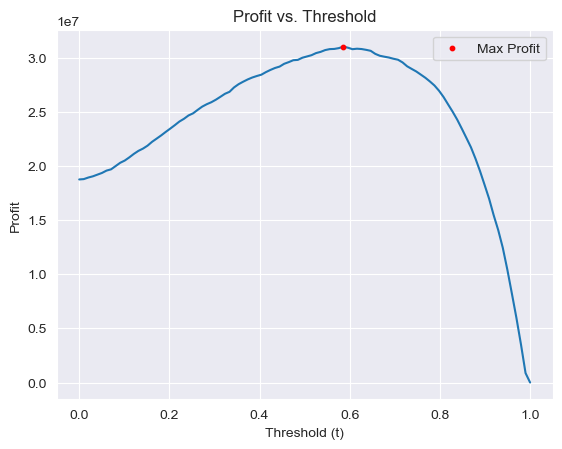

In [16]:
plt.plot(threshold_values, profits)
plt.xlabel('Threshold (t)')
plt.ylabel('Profit')
plt.title('Profit vs. Threshold')
plt.grid(True)
plt.scatter(optimal_t, optimal_profit, color='red', label='Max Profit', zorder=5, s=10)
plt.legend() 
plt.show()

## PART D: EVALUATION FROM THE BANK'S PERSPECTIVE

In order to evaluate the model from the perspective of the bank, I ran the same preprocessing and score-finding steps on the test data, then used the previously found threshold to determine the profit made.

In [17]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

In [18]:
features = df_test.columns
entries_to_remove = ["loan_grade"]
features = [x for x in features if x not in entries_to_remove]
features

from sklearn.preprocessing import LabelEncoder

df_testfit = df_test[features]

home_dict = {}
le = LabelEncoder()
le.fit(df_testfit["person_home_ownership"])
for i, c in enumerate(le.classes_):
    home_dict.update({i: c})
df_testfit['person_home_ownership']  = le.transform(df_testfit["person_home_ownership"])

cb_person_default_dict = {}
le.fit(df_testfit["cb_person_default_on_file"])
for i, c in enumerate(le.classes_):
    cb_person_default_dict.update({i: c})
df_testfit['cb_person_default_on_file']  = le.transform(df_testfit["cb_person_default_on_file"])

loan_intent_dict = {}
le.fit(df_testfit["loan_intent"])
df_testfit['loan_intent']  = le.transform(df_testfit["loan_intent"])
for i, c in enumerate(le.classes_):
    loan_intent_dict.update({i: c})
df_testfit = df_testfit.dropna()

/var/folders/b9/j0x1vdx94513n863t09wz2d80000gn/T/ipykernel_22046/464385379.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testfit['person_home_ownership']  = le.transform(df_testfit["person_home_ownership"])
/var/folders/b9/j0x1vdx94513n863t09wz2d80000gn/T/ipykernel_22046/464385379.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testfit['cb_person_default_on_file']  = le.transform(df_testfit["cb_person_default_on_file"])
/var/folders/b9/j0x1vdx94513n863t09wz2d80000gn/T/ipykernel_22046/46438

In [19]:
features = ['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length']

testpred = LR.predict_proba(df_testfit[features])
first_column_list = testpred[:, 0].tolist()
print(first_column_list)
df_testfit['score'] = first_column_list


[0.812731880077114, 0.7126820666303045, 0.7932308904484366, 0.861124725203076, 0.6979081869958387, 0.9142337543969793, 0.9819306626577028, 0.9792602735830128, 0.9509611545404288, 0.9526690237147517, 0.9794407577309987, 0.2872711483298629, 0.9737496086220121, 0.8462536047734652, 0.883826447652331, 0.37182270174461074, 0.992691887597662, 0.9089333882251871, 0.924302609889193, 0.9109245866409538, 0.9002948171328657, 0.9614892116279882, 0.9330742156675325, 0.8353096565092055, 0.7368369827045023, 0.8920059908262402, 0.7029906858651715, 0.9760497091796799, 0.8891865660331308, 0.908925836956565, 0.9051512740593382, 0.9463834051219878, 0.8554430777810542, 0.4414715735220851, 0.8100661322303163, 0.7937174618474026, 0.9757833098410614, 0.8428457445411042, 0.9224936996324817, 0.9093272280842479, 0.5457358731383652, 0.4300398626376367, 0.7665181584875673, 0.7699503755835111, 0.8913331016916353, 0.9351608933002026, 0.747961173441905, 0.9194427347664375, 0.9529421402490348, 0.6864648841149554, 0.900

In [20]:
profit = profit_finder(0.6047470824523236, df_testfit)
profit

7350431.521690609

## PART E: EVALUATION FROM THE BORROWER'S PERSPECTIVE

### Is it more difficult for people in certain age groups to access credit under your proposed system?

To answer this question, I seperated applicants into one of five age groups, increasing by 10s until age 70, and graphed their relative scores.

/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


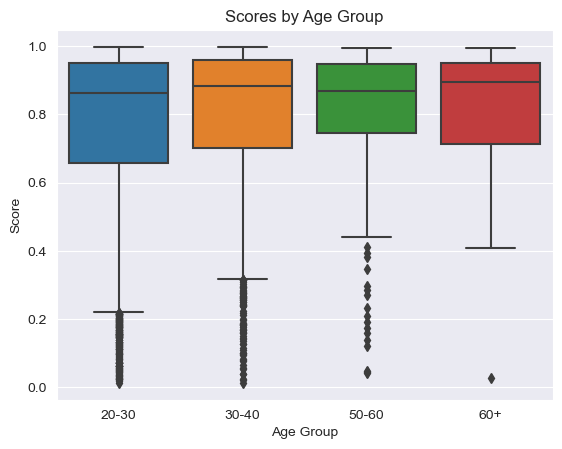

In [21]:
# AGE

bins = [20, 30, 40, 50, 60]
labels = ['20-30', '30-40', '50-60', '60+']
df_testfit['age_group'] = pd.cut(df_testfit['person_age'], bins=bins, labels=labels, right=False)




sns.boxplot(x=df_testfit['age_group'], y=df_testfit['score'])
plt.xlabel('Age Group')
plt.ylabel('Score')
plt.title('Scores by Age Group')
plt.show()

Generally, looking at this graph I don't see an enourmous variation in scores by age group, although applicants who are 30-40 and 70+ generally have slightly higher scores.

### Is it more difficult for people to get loans in order to pay for medical expenses? How does this compare with the actual rate of default in that group? What about people seeking loans for business ventures or education?

To answer this question, I created a dataframe that contained the percentage of approvals by loan intent as well as the percentage of complete repayments by loan intent. 

In [22]:
approved = df_testfit.groupby('loan_intent')['score'].apply(lambda x: (x > optimal_t).sum())
total_counts = df_testfit['loan_intent'].value_counts()
percentage_above_threshold = (approved / total_counts) * 100
intent_df = pd.DataFrame({'loan intent': loan_intent_dict, 'perc approved': percentage_above_threshold})

paid = df_testfit.groupby('loan_intent')['loan_status'].apply(lambda x: (x == 0).sum())
percentage_paid = (paid / total_counts) * 100
intent_df['perc repaid'] = percentage_paid

intent_df

,loan intent,perc approved,perc repaid
0,DEBTCONSOLIDATION,75.000000,71.238938
1,EDUCATION,79.336735,83.248299
2,HOMEIMPROVEMENT,82.792208,75.000000
3,MEDICAL,81.267474,71.575023
4,PERSONAL,84.368737,77.955912
5,VENTURE,86.929461,85.373444


From this data we see that generally loans for education and venture are approved at higher rates than medical loans, but are also paid back at a higher rate than medical loans.

### How does a person’s income level impact the ease with which they can access credit under your decision system?

To answer this question I group applicants into five income categories, and graphed, similar to my age graph, the scores of each group.

In [23]:
print(df_testfit['person_income'].min())
print(df_testfit['person_income'].max())
print(df_testfit['person_income'].median())

4800
1782000
55000.0


/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


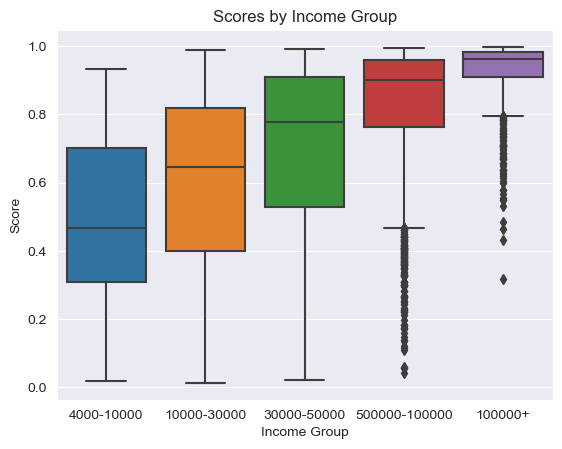

In [24]:
bins = [df_testfit['person_income'].min(), 10000, 30000, 50000, 100000, df_testfit['person_income'].max()]
labels = ['4000-10000', '10000-30000', '30000-50000', '500000-100000', '100000+']
df_testfit['income_group'] = pd.cut(df_testfit['person_income'], bins=bins, labels=labels, right=False)




sns.boxplot(x=df_testfit['income_group'], y=df_testfit['score'])
plt.xlabel('Income Group')
plt.ylabel('Score')
plt.title('Scores by Income Group')
plt.show()

This graph shows that as income increases, the chances of loan approval (risk score) increases as well.

## DISCUSSION

Through writing this blogpost I learned about the multiple variables that effect a model's outcomes, and methods through which to optimize these variables, including threshold values and weights. My findings indicate that, through this very simplistic model of loan approval, a bank is able to make a very large profit on loans. Analyzing the model created, we see generally expected trends in approval rates by income, with higher income logically increasing chances of approval, as they are more likely to be able to pay off the entirety of the loan. No strong trend was seen in variance by age, though generally 20-30 year olds were marked as slightly riskier. This again makes sense given their comparative status in the job market, where they likely are in more junior positions with lower pay and less security. 

Another trend seen in the model was that loans marked for medical purposes were labelled riskier than other loan purposes. To me, although this is understandably a tough decision/thing to place a score on as medical loans are more likely to be urgent or even life-threatening, the way the the model scores medical loans does seem fair. Obviously, the fact that medical bills are so outrageously expensive that people are forced to apply for loans to access the healthcare they need is a huge public policy issue that needs immediate change, but at the same time, a bank itself, which theoretically does not have influence over such policy aspects, has to look out for its own survival as well, and needs to take into account that these loans do have a higher default rate than others. Approving these loans despite that fact could lead to loss in profits that could lead to undesirable outcomes like lay-offs and salary cuts which also effect the lives of people. To me, the scores seem fair, following the definition of fairness that means free from blind injustice and discrimination.